Mean Squared Error of Predictions: 129.00


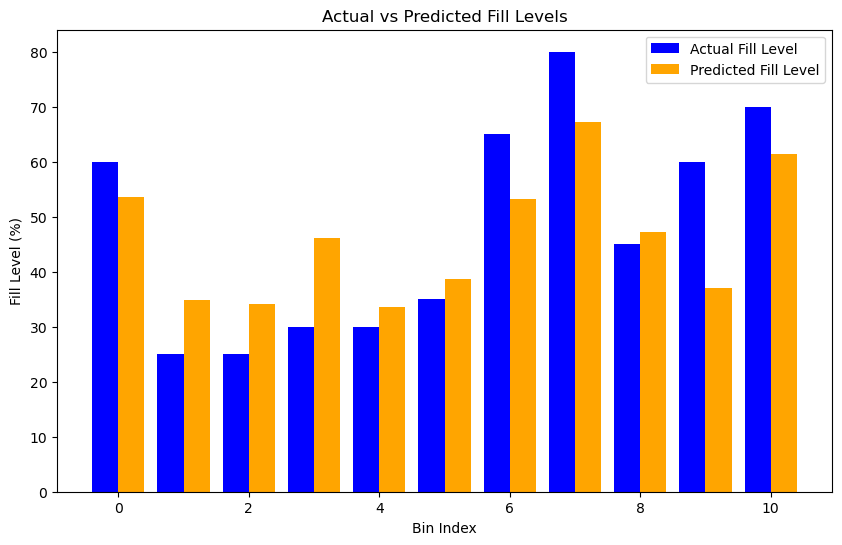

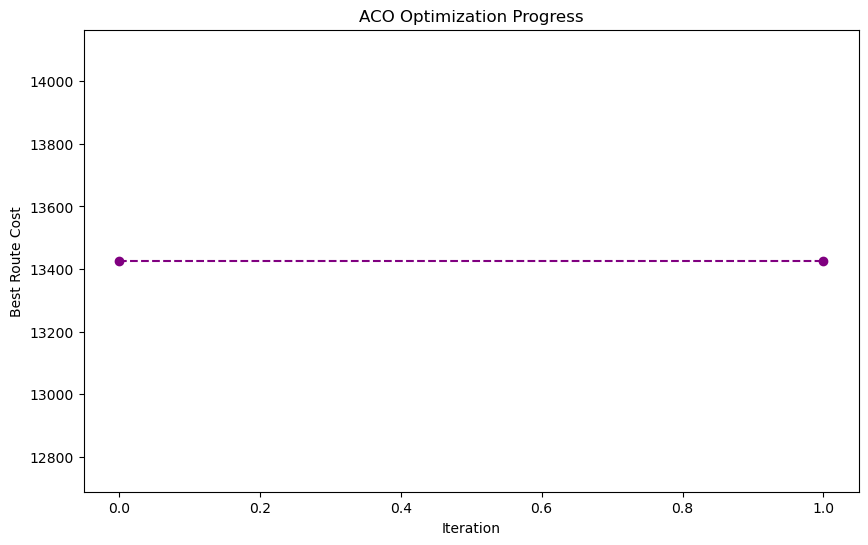

TwilioRestException: HTTP 404 error: Unable to create record: The requested resource /2010-04-01/Accounts/ACbbdd759ad6988d7e5f2c089d334c8374/Messages.json was not found

In [1]:
import folium
import networkx as nx
import numpy as np
import pandas as pd
import random
import osmnx as ox
from folium.plugins import AntPath
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Example data (replace with your actual data)
data = {
    'latitude': [
        16.306655, 16.310131, 16.293640, 16.294161, 16.311354, 
        16.302529, 16.290426, 16.294317, 16.305136, 16.305994, 16.315700     
    ],
    'longitude': [
        80.436711, 80.430577, 80.454553, 80.438822, 80.434456,
        80.423046, 80.450237, 80.462807, 80.453737, 80.447360, 80.417653
    ],
    'fill_level': [
        60, 25, 55, 70, 30, 75, 65, 80, 45, 60, 70
    ]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Filter bins by fill level
filled_bins = df[df['fill_level'] > 50]  # Filled bins (red)
unfilled_bins = df[df['fill_level'] <= 50]  # Unfilled bins (blue)

# Create a road network graph using osmnx
G = ox.graph_from_place('Guntur, India', network_type='drive')

# Define the new fixed starting location (latitude and longitude near the bin locations)
fixed_start_location = (16.300000, 80.440000)
fixed_start_node = ox.distance.nearest_nodes(G, fixed_start_location[1], fixed_start_location[0])

# Update bin nodes dictionary to include fixed start point
bin_nodes = {index: ox.distance.nearest_nodes(G, row['longitude'], row['latitude']) for index, row in filled_bins.iterrows()}
bin_nodes['Start/End'] = fixed_start_node  # Add the start/end node with a unique name

# Updated ACO to start from fixed start node and return to it
def ant_colony_optimization(graph, bin_nodes, iterations=600, num_ants=60, alpha=2.0, beta=3.0, rho=0.4, Q=150):
    nodes = list(bin_nodes.keys())
    start_node = 'Start/End'
    num_nodes = len(nodes)
    pheromones = np.ones((num_nodes, num_nodes))  # Pheromone matrix
    best_route = None
    best_cost = float('inf')
    no_improvement_count = 0  # Counter for early stopping
    best_costs = []  # Track best cost for each iteration for plotting

    # ACO iterations
    for iteration in range(iterations):
        ant_routes = []

        # Construct solutions (routes) with each ant, starting from fixed start node
        for ant in range(num_ants):
            current_node = start_node
            route = [current_node]
            visited = set([current_node])

            # Build the route for the current ant
            while len(visited) < num_nodes:
                unvisited = list(set(nodes) - visited)
                probabilities = []
                total_prob = 0.0
                for neighbor in unvisited:
                    pheromone_level = pheromones[nodes.index(current_node)][nodes.index(neighbor)]
                    path = nx.shortest_path(graph, bin_nodes[current_node], bin_nodes[neighbor], weight='length')
                    distance = nx.path_weight(graph, path, weight='length')
                    probability = (pheromone_level * alpha) * ((1.0 / distance) * beta)
                    probabilities.append((neighbor, probability))
                    total_prob += probability
                probabilities = [(neighbor, prob / total_prob) for neighbor, prob in probabilities]
                next_node = random.choices(unvisited, weights=[prob for node, prob in probabilities])[0]

                # Move to the next node
                route.append(next_node)
                visited.add(next_node)
                current_node = next_node

            # Return to start node to complete the route
            route.append(start_node)
            ant_routes.append(route)

        # Update pheromone levels
        pheromone_delta = np.zeros((num_nodes, num_nodes))
        for route in ant_routes:
            route_cost = sum(nx.path_weight(graph, nx.shortest_path(graph, bin_nodes[route[i]], bin_nodes[route[i + 1]], weight='length'), weight='length') for i in range(len(route) - 1))
            for i in range(len(route) - 1):
                pheromone_delta[nodes.index(route[i])][nodes.index(route[i + 1])] += Q / route_cost

        pheromones = (1.0 - rho) * pheromones + pheromone_delta

        # Update best route found
        for route in ant_routes:
            route_cost = sum(nx.path_weight(graph, nx.shortest_path(graph, bin_nodes[route[i]], bin_nodes[route[i + 1]], weight='length'), weight='length') for i in range(len(route) - 1))
            if route_cost < best_cost:
                best_route = route
                best_cost = route_cost
                no_improvement_count = 0  # Reset early stopping counter on improvement
            else:
                no_improvement_count += 1  # Increment early stopping counter

        best_costs.append(best_cost)  # Record best cost for plotting

        # Early stopping criteria (terminate if no improvement for a certain number of iterations)
        if no_improvement_count >= 100:
            break

    return best_route, best_cost, best_costs

# Example usage
best_route, best_cost, best_costs = ant_colony_optimization(G, bin_nodes)

# Create a map with fixed start/end point and bin markers
map_center = df[['latitude', 'longitude']].mean().values.tolist()
mymap = folium.Map(location=map_center, zoom_start=12)

# Plot filled (red) and unfilled (blue) bins
for _, row in filled_bins.iterrows():
    folium.Marker(
        location=(row['latitude'], row['longitude']),
        icon=folium.Icon(color='red', icon='info-sign')  # Location symbol for filled bins
    ).add_to(mymap)

for _, row in unfilled_bins.iterrows():
    folium.Marker(
        location=(row['latitude'], row['longitude']),
        icon=folium.Icon(color='blue', icon='info-sign')  # Location symbol for unfilled bins
    ).add_to(mymap)

# Plot start/end location with its name
folium.Marker(
    location=(fixed_start_location[0], fixed_start_location[1]),
    icon=folium.Icon(color='green', icon='play'),
    popup="Depot"
).add_to(mymap)

# Plot the best route (starting and ending at fixed start/end location)
route_points = [bin_nodes[node] for node in best_route]
path_coords = []
for i in range(len(route_points) - 1):
    path = nx.shortest_path(G, route_points[i], route_points[i + 1], weight='length')
    path_coords.extend([(G.nodes[n]['y'], G.nodes[n]['x']) for n in path])

# Add AntPath for the route
AntPath(path_coords, color='green', weight=8, delay=1000, dash_array=[10, 20]).add_to(mymap)

# Save the map
mymap.save('route_optimization_map_filled_unfilled.html')

# Plot fill levels as bar chart
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['fill_level'], color=['red' if level > 50 else 'blue' for level in df['fill_level']])
plt.xlabel("Bin Index")
plt.ylabel("Fill Level (%)")
plt.title("Fill Levels of Bins")
plt.savefig('fill_levels_chart.png')
plt.show()

# Plot ACO progress over iterations
plt.figure(figsize=(10, 6))
plt.plot(best_costs, color='purple', linestyle='--', marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best Route Cost")
plt.title("ACO Optimization Progress")
plt.savefig('aco_progress_chart.png')
plt.show()

# Display best route and cost
best_route_labels = [node if node != 'Start/End' else 'Depot' for node in best_route]
print("Best Route:", best_route_labels)
print("Best Cost:", best_cost)
print("Map saved to 'route_optimization_map_filled_unfilled.html'")
print("Fill levels chart saved as 'fill_levels_chart.png'")
print("ACO progress chart saved as 'aco_progress_chart.png'")